In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [3]:
# 道路名
# TARGET_ROAD='tateyama'
TARGET_ROAD='kannetsu'

# 交通量
PROCESSED_DATA_DIR = '../Input_processed_data'
TRAFFIC_DIR = f'{PROCESSED_DATA_DIR}/traffic'
TRAFFIC_CSV = f'{TRAFFIC_DIR}/{TARGET_ROAD}_20220621all-merged_filled_15min.csv'

In [6]:
df = pd.read_csv(TRAFFIC_CSV, parse_dates=True, index_col='datetime',
                dtype={'start_code': str, 'end_code': str, 'road_code': str}).reset_index()

/tmp/ipykernel_704878/2438094643.py:1: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(TRAFFIC_CSV, parse_dates=True, index_col='datetime',


In [7]:
start_date='2021/5/1'
end_date='2021/6/1'

df_test = df.loc[(df['datetime'] >= pd.Timestamp(start_date)) & (df['datetime'] < pd.Timestamp(end_date))]
df_test.reset_index(drop=True, inplace=True)

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187488 entries, 0 to 187487
Data columns (total 52 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   datetime             187488 non-null  datetime64[ns]
 1   index                187488 non-null  int64         
 2   start_name           187488 non-null  object        
 3   end_name             187488 non-null  object        
 4   start_code           187488 non-null  object        
 5   end_code             187488 non-null  object        
 6   start_pref_code      187488 non-null  int64         
 7   end_pref_code        187488 non-null  int64         
 8   start_lat            187488 non-null  float64       
 9   end_lat              187488 non-null  float64       
 10  start_lng            187488 non-null  float64       
 11  end_lng              187488 non-null  float64       
 12  start_degree         187488 non-null  float64       
 13  end_degree    

In [9]:
def preprocess(df):
    df['year'] = df['datetime'].dt.year
    
    df['jam_quantity'] = np.where(df['jam_quantity'] > 0, 1, 0)
    
    direction_map = {'上り': 0, '下り': 1}
    df['direction'] = df['direction'].map(direction_map)
    
    df['quarter'] = df['quarter'].str[-1]
    
    drop_cols = ['road_code', 'weather_description', 'jam_type']
    df.drop(drop_cols, axis=1, inplace=True)
    
    type_map = {
        'direction': np.uint8,
        'quarter': np.uint8,
        'allCars': np.float32,
        'speed': np.float32,
        'jam_quantity': np.uint8,
        'search_15min': int,
        'search_1h': int,
        'search_unspec_1d': int,
        'search_unspec_3d': int,
        'search_unspec_7d': int,
        'search_unspec_10d': int,
    }
    df = df.astype(type_map)
    
    return df

In [10]:
df_test = preprocess(df_test.copy())

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187488 entries, 0 to 187487
Data columns (total 50 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datetime           187488 non-null  datetime64[ns]
 1   index              187488 non-null  int64         
 2   start_name         187488 non-null  object        
 3   end_name           187488 non-null  object        
 4   start_code         187488 non-null  object        
 5   end_code           187488 non-null  object        
 6   start_pref_code    187488 non-null  int64         
 7   end_pref_code      187488 non-null  int64         
 8   start_lat          187488 non-null  float64       
 9   end_lat            187488 non-null  float64       
 10  start_lng          187488 non-null  float64       
 11  end_lng            187488 non-null  float64       
 12  start_degree       187488 non-null  float64       
 13  end_degree         187488 non-null  float64 

In [12]:
def fillna(df, col):
    f = lambda gs: gs.interpolate(method='linear', axis=0)
    df[col] = df.groupby(['start_code', 'end_code'])[col].apply(f)
    return df

In [13]:
df_test = fillna(df_test, 'speed')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187488 entries, 0 to 187487
Data columns (total 50 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datetime           187488 non-null  datetime64[ns]
 1   index              187488 non-null  int64         
 2   start_name         187488 non-null  object        
 3   end_name           187488 non-null  object        
 4   start_code         187488 non-null  object        
 5   end_code           187488 non-null  object        
 6   start_pref_code    187488 non-null  int64         
 7   end_pref_code      187488 non-null  int64         
 8   start_lat          187488 non-null  float64       
 9   end_lat            187488 non-null  float64       
 10  start_lng          187488 non-null  float64       
 11  end_lng            187488 non-null  float64       
 12  start_degree       187488 non-null  float64       
 13  end_degree         187488 non-null  float64 

In [19]:
usecols = ['hour', 'dayofweek', 'is_holiday', 'lane_count', 'allCars', 'speed', 'OCC', 'search_15min', 'search_1h', 'search_unspec_1d']
target = 'jam_quantity'

In [20]:
df_X = df_test.loc[:, ['datetime', 'start_name', 'end_name'] + usecols]
df_y = df_test.loc[:, target]

df_X.sort_values('datetime', inplace=True)

In [21]:
N_period = df_X.drop_duplicates("datetime").shape[0]
N_sec = df_X.drop_duplicates(["start_name", "end_name"]).shape[0]
N, F = df_X.shape[0], len(usecols)

print(f'データ数（期間 x 区間数） x 特徴量数: {(N, F)}')
print(f'期間（15min x 31day）: {N_period} ({31 * 24 * 4})')
print(f'区間数: {N_sec}')

データ数（期間 x 区間数） x 特徴量数: (187488, 10)
期間（15min x 31day）: 2976 (2976)
区間数: 63


In [22]:
X = np.empty((N_sec, N_period, F), dtype=np.float32)
y = np.empty((N_sec, N_period), dtype=np.float32)

print(X.shape, y.shape)

(63, 2976, 10) (63, 2976)


In [23]:
group = df_test.groupby(['start_code', 'end_code'])
for i, (g_key, df_g) in enumerate(group):
    X[i] = df_g.loc[:, usecols].values
    y[i] = df_g.loc[:, target].values

print(X.shape, y.shape)

(63, 2976, 10) (63, 2976)


In [24]:
# 正規化
mean = X.reshape(-1, F).mean(axis=0)
std = X.reshape(-1, F).std(axis=0)

X_norm = (X - mean) / std

In [25]:
# A-B-C-D x 各区間10個ずつ
batch_size = 2
time_step = 3

# AB0, AB1, AB2, ..., AB9
# BC0, BC1, BC2, ..., BC9
# CD0, CD1, CD2, ..., CD9

# ABに限定するのであれば
# [AB0, AB1, AB2], [AB1, AB2, AB3], ..., [AB7, AB8, AB9] -> 7個できる

# バッチ数を区間数の倍数にすればいい？
# [[AB0, AB1, AB2]
# [BC0, BC1, BC2]
# [CD0, CD1, CD2]]

# 下みたいに区間に対応するラベルさえしっかり出力できるなら問題ない
# [[AB0, AB1, AB2] -> AB3
# [AB1, AB2, AB3] -> AB4
# [AB5, AB6, AB7] -> AB8
# [BC2, BC3, BC4] -> BC5
# [BC7, BC8, BC9] -> BC10
# [CD0, CD1, CD2]] -> CD3

In [28]:
train_ratio = 0.8
ind_split = int(X_norm.shape[1] * train_ratio)
X_train, X_val = X_norm[:, :ind_split], X_norm[:, ind_split:]
y_train, y_val = y[:, :ind_split], y[:, ind_split:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(63, 2380, 10) (63, 2380)
(63, 596, 10) (63, 596)


In [48]:
# LSTM用のtime step, 区間のstackの処理はdatasetに投げる
# dataloaderはミニバッチに区切るだけ
class LSTMData(torch.utils.data.Dataset):
    def __init__(self, data_X, data_y, time_step):
        X, y = self.__sliding_window(data_X, data_y, time_step)       
        self.X = X
        self.y = y
        self.time_step = time_step

        
    def __len__(self):
        return self.X.shape[0]


    def __getitem__(self, index):
        return self.X[index], self.y[index]

    
    def __sliding_window(self, data_X, data_y, time_step):
        N_sections, N_periods, _ = data_X.shape
        X = []
        y = []
        
        for i in range(N_sections):
            # 各区間ごとにtime step分だけ切り出す
            for t in range(N_periods-time_step):
                x_ = data_X[i, t:t+time_step]
                y_ = data_y[i, t+time_step]
                X.append(x_)
                y.append(y_)
        
        X = torch.from_numpy(np.array(X, dtype=np.float32))
        y = torch.from_numpy(np.array(y, dtype=np.uint8))
        return X, y

In [30]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_first=True):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        outs, (h, c) = self.lstm(x)
        out = self.fc(h[0])
        return out

In [51]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    model.train()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        val_loss = 0.0
        
        for data, target in train_loader:
            data = data.to(device=device)
            target = target.to(device=device)
            
            out = model(data)
            
            loss = loss_fn(out, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        with torch.no_grad():
            for data, target in val_loader:
                data = data.to(device=device)
                target = target.to(device=device)

                out = model(data)
                loss = loss_fn(out, target)

                val_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        
        if epoch <= 3 or epoch % 50 == 0:
            log = f'{dt.datetime.now()} | Epoch: {epoch}, Train Loss: {train_loss / len(train_loader)}, Valid Loss: {val_loss / len(val_loader)}'
            print(log)
            
            with open('./logs_jam.txt', mode='a') as f:
                f.write(log + '\n')
        
    return train_losses, val_losses

In [52]:
time_step = 12
batch_size = 64

dataset_train = LSTMData(X_train, y_train, time_step)
dataset_valid = LSTMData(X_val, y_val, time_step)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [53]:
n_epochs = 3000
input_dim = X_train.shape[-1]
hidden_dim = 100
out_dim = 2
num_layers = 1

model = Net(input_dim, hidden_dim, out_dim, num_layers).to(device=device)
optimizer = optim.Adam(model.parameters())

loss_fn = nn.CrossEntropyLoss()

train_losses, val_losses = train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader)

2022-07-21 17:49:42.817336 | Epoch: 1, Train Loss: 0.014042138176349146, Valid Loss: 0.006704302439194061
2022-07-21 17:49:49.783694 | Epoch: 2, Train Loss: 0.008260724150650982, Valid Loss: 0.005993778709006342
2022-07-21 17:49:56.754825 | Epoch: 3, Train Loss: 0.0077999682085283534, Valid Loss: 0.0060051832659543
2022-07-21 18:00:51.906928 | Epoch: 100, Train Loss: 0.0005608973504087967, Valid Loss: 0.018378329794107754
2022-07-21 18:06:31.590430 | Epoch: 150, Train Loss: 0.0004709791571400529, Valid Loss: 0.022369424873077703
2022-07-21 18:12:07.366916 | Epoch: 200, Train Loss: 0.0007067382246639479, Valid Loss: 0.022633133532938218
2022-07-21 18:17:43.184402 | Epoch: 250, Train Loss: 0.0003017610126834194, Valid Loss: 0.021393064902682713
2022-07-21 18:23:18.768309 | Epoch: 300, Train Loss: 9.533357414327356e-05, Valid Loss: 0.02000047421523229
2022-07-21 18:28:52.253990 | Epoch: 350, Train Loss: 0.0003104695155759381, Valid Loss: 0.02420411152802001
2022-07-21 18:34:28.037443 | Ep

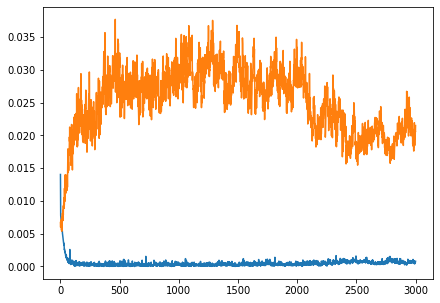

In [70]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(range(len(train_losses)), train_losses)
ax.plot(range(len(val_losses)), val_losses)
plt.show()

In [66]:
def validate(model, train_loader, val_loader):
    model.eval()
    
    loss_dict = {
        'train': [],
        'valid': []
    }
    for name, loader in [('train', train_loader), ('valid', val_loader)]:    
        with torch.no_grad():
            tp, fp, fn, tn = 0, 0, 0, 0
            total = 0
            
            for data, target in loader:
                data = data.to(device=device)
                target = target.to(device=device)
                
                out = model(data)
                _, predicted = torch.max(out, dim=1)
                _tp = ((predicted == 1) & (target == 1)).sum()
                _fp = ((predicted == 1) & (target == 0)).sum()
                _fn = ((predicted == 0) & (target == 1)).sum()
                _tn = ((predicted == 0) & (target == 0)).sum()
                
                total += target.shape[0]
                # correct += (target == predicted).sum()
                tp += _tp
                fp += _fp
                fn += _fn
                tn += _tn
                
                loss = loss_fn(out, target)
                loss_dict[name].append(loss.item())
            
            acc = (tp + tn) / total
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = 2 * precision * recall / (precision + recall)
            
            print(f'{name} Accuracy: {acc:.3f}')
            print(f'{name} Precision: {precision:.3f}')
            print(f'{name} Recall: {recall:.3f}')
            print(f'{name} f1: {f1:.3f}')
    return loss_dict

In [65]:
loss_dict = validate(model, train_loader, val_loader)

train Accuracy: 1.000
train Precision: 0.992
train Recall: 0.989
train f1: 0.990
valid Accuracy: 0.998
valid Precision: 0.652
valid Recall: 0.469
valid f1: 0.545


In [83]:
with torch.no_grad():
    for data, target in dataset_train:
        if target == 1:
            break
    
    out = model(data.to(device=device))
    print(data)
    print(out)

tensor([[-0.9403,  0.9315,  1.1769, -0.0476,  2.5836, -1.9690,  2.5864,  3.5268,
          4.6305,  2.7856],
        [-0.7957,  0.9315,  1.1769, -0.0476,  2.6572, -3.0978,  2.8593,  7.7675,
          5.7147,  2.7856],
        [-0.7957,  0.9315,  1.1769, -0.0476,  3.7302, -4.7100,  4.7699,  4.1792,
          5.7147,  2.7856],
        [-0.7957,  0.9315,  1.1769, -0.0476,  3.5460, -4.2918,  4.3605,  8.3112,
          5.7147,  2.7856],
        [-0.7957,  0.9315,  1.1769, -0.0476,  3.7440, -6.6003,  6.1345,  2.6569,
          5.7147,  2.7856],
        [-0.6510,  0.9315,  1.1769, -0.0476,  3.4263, -3.8699,  3.9511,  5.0491,
          4.6924,  2.7856],
        [-0.6510,  0.9315,  1.1769, -0.0476,  3.6013, -4.5119,  4.3605,  2.8744,
          4.6924,  2.7856],
        [-0.6510,  0.9315,  1.1769, -0.0476,  3.1868, -3.0149,  3.4052,  4.8317,
          4.6924,  2.7856],
        [-0.6510,  0.9315,  1.1769, -0.0476,  3.5690, -3.5150,  3.9511,  5.9190,
          4.6924,  2.7856],
        [-0.5063,  